### 新古典派成長モデルの時間反復法による数値解法
代表的個人の問題は以下のように書ける
\begin{align*}
 && \underset{{c_{t},k_{t+1}}}{\max} \sum_{t=0}^{\infty} \beta^t u(c_t) \\
 \text{subject to} && c_t + k_{t+1} = f(k_t), \\
 && k_0 \text{ is given.}
\end{align*}
ここで、$u(c)=\frac{c^{1-\sigma}}{1-\sigma}, f(k)=k^{\alpha}+(1-\delta)k$

In [3]:
#必要な関数・モジュールを呼び出す
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import japanize_matplotlib
from CRRA import CRRA, mu_CRRA
from EulerEq import EulerEq
from nti import nti
import time

In [4]:
#カリブレーション
class Model():
    """
    モデルを解くためのパラメータを含む class を定義する。
    """
    def __init__(self,
        beta = 0.96,    # 割引因子
        gamma = 1.0,    # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        alpha = 0.4,    # 資本分配率 
        delta = 1.0,    # 固定資本減耗
        nk = 21,        # 資本のグリッド数
        kmax = 0.5,     # 資本グリッドの最大値
        kmin = 0.05,    # 資本グリッドの最小値
        maxiter = 1000, # 繰り返し計算の最大値
        tol = 1e-5,     # 許容誤差(STEP2)
        ): 
        
        self.beta, self.gamma, self.alpha = beta, gamma, alpha 
        self.delta, self.nk = delta, nk 
        self.kmax, self.kmin = kmax, kmin 
        self.kgrid = np.linspace(kmin,kmax,nk) # 資本のグリッド
        self.maxiter, self.tol = maxiter, tol

### オイラー方程式
オイラー方程式は以下で与えられる
\begin{equation*}
u^{\prime}(c_{t}) = \beta u^{\prime}(c_{t+1})f^{\prime}(k_{t+1})
\end{equation*}

ここで、$u^{\prime}(c)=c^{-\sigma}, f^{\prime}(k)=\alpha k^{\alpha-1}+(1-\delta)$

### アルゴリズム
#### 1. グリッド生成
a. 状態空間を有限個のグリッド$\{k_1,k_2,\dots,k_N\}$に区切る

b. グリッド上の政策関数の初期値$c=h(k_i)$を当て推量する

#### 2. 収束の基準
収束の基準になるパラメータ$\varepsilon$を与える

#### 3. 近似・評価
グリッドの点$k_i$上にない政策関数の値については、線形近似やスプライン近似を使って補間する

$h(k,\mathbf{b})$をパラメータのベクトル$\mathbf{b}$（ここでは関数\texttt{Spline1D}によって暗黙に与えられる）を使って近似したときの、$k$上での政策関数の値とする

#### 4. 最適化
古い政策関数$h^{(n-1)}(k)$を所与として、各$k_i$について、
\begin{equation*}
u^{\prime}(c) = \beta u^{\prime} \left( h^{(n-1)}(f(k_i)-c;\mathbf{b}) \right) f^{\prime}(f(k_i)-c)
\end{equation*}
を$c$について解く

このステップで、新しい政策関数$c=h^{(n)}(k)$を得る

#### 5. 収束の確認
全ての$k_i$について、$\| h^{(n)}(k_i)-h^{(n-1)}(k_i) \| < \varepsilon$であればストップ

そうでなければ、$h^{(n)}(k)$を$h^{(n-1)}(k)$に代入して、ステップ3とステップ4を繰り返す

In [5]:
start = time.time()

print("")
print("-+- Solve a neoclassical growth model with time iteration -+-")
print("")

m = Model()
mu_CRRA_vec = np.vectorize(mu_CRRA)

#時間反復法を実施
cfcn0 = nti(m)

end = time.time() - start

#最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 =  (m.kgrid ** m.alpha) + (1-m.delta)*m.kgrid - cfcn0 

print("")
print(f"running time is {end:.5f}")
print("")


-+- Solve a neoclassical growth model with time iteration -+-

iteration index: 1
policy function iteration error: 0.09823124494179641
iteration index: 2
policy function iteration error: 0.03169528051254489
iteration index: 3
policy function iteration error: 0.011352015515084635
iteration index: 4
policy function iteration error: 0.005531451510248142
iteration index: 5
policy function iteration error: 0.0023286829951926213
iteration index: 6
policy function iteration error: 0.0009272273840633671
iteration index: 7
policy function iteration error: 0.0003611997016131352
iteration index: 8
policy function iteration error: 0.00013949230638043986
iteration index: 9
policy function iteration error: 5.368651380616152e-05
iteration index: 10
policy function iteration error: 2.0634279521758447e-05
iteration index: 11
policy function iteration error: 7.926445888928324e-06

running time is 0.13589



### 解析解との比較、計算誤差
$\delta=1$のとき、政策関数には解析解が存在する
\begin{equation*}
k^{\prime}=\alpha\beta k^{\alpha}, c=(1-\alpha\beta) k^{\alpha}
\end{equation*}

In [6]:
#解析的解(for k'=g(k))
p_true = m.beta * m.alpha * (m.kgrid ** m.alpha)

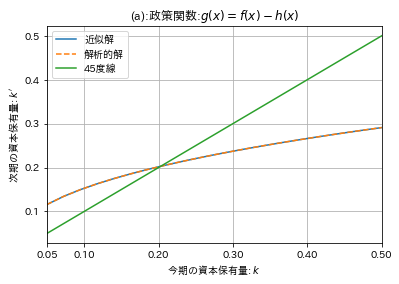

In [7]:
fig, ax = plt.subplots()
ax.plot(m.kgrid,pfcn0,label="近似解")
ax.plot(m.kgrid,p_true,ls="--",label="解析的解")
ax.plot(m.kgrid,m.kgrid,label="45度線")
ax.set(xlabel=r"今期の資本保有量: $k$",ylabel=r"次期の資本保有量: $k'$",title=r"(a):政策関数:$g(x)=f(x)-h(x)$",
xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4,0.5])
ax.legend(loc="upper left")
ax.grid()
plt.show()

数値解により得られた政策関数$c=h(k;\mathbf{b})$をオイラー方程式に代入して、誤差
\begin{equation*}
\frac{\beta u^{\prime} \left( h(\underbrace{f(k)-h(k;\mathbf{b})}_{k^{\prime}};\mathbf{b}) \right) f^{\prime}(\underbrace{f(k)-h(k;\mathbf{b})}_{k^{\prime}})
}{u^{\prime}(h(k;\mathbf{b}))}-1
\end{equation*}
を計算できる。近似に用いたグリッド上では計算誤差はほぼゼロに等しい

In [8]:
#オイラー方程式から誤差を測定
kgrid_err = np.linspace(m.kmin,m.kmax,(m.nk-1)*10+1)
cons_interp = interp1d(m.kgrid,cfcn0,kind="linear",fill_value="extrapolate")
cons = cons_interp(kgrid_err)
LHS = mu_CRRA_vec(m,cons)

kp = (kgrid_err ** m.alpha) + (1-m.delta)*kgrid_err - cons
cnext = cons_interp(kp)
rent = m.alpha*(kp ** (m.alpha-1)) - m.delta
RHS = m.beta * (1+rent) * mu_CRRA_vec(m,cnext)

err = (RHS/LHS) - 1

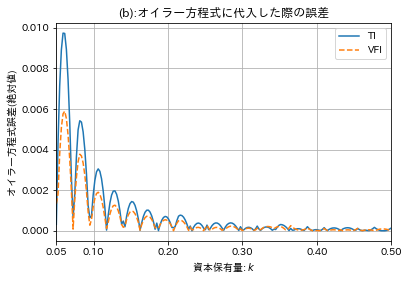

In [9]:
f = open("err_ndp.csv",encoding='utf-8-sig')
err2 = np.loadtxt(f) #VFIでのオイラー方程式誤差

fig, ax = plt.subplots()
ax.plot(kgrid_err,np.abs(err),label="TI")
ax.plot(kgrid_err,np.abs(err2),ls="--",label="VFI")
ax.set(xlabel=r"資本保有量: $k$",ylabel="オイラー方程式誤差(絶対値)",title="(b):オイラー方程式に代入した際の誤差",
xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4,0.5])
ax.legend(loc="upper right")
ax.grid()
plt.show()

In [10]:
#TIとVFIでのオイラー方程式誤差を比較する
L1_TI = np.log10(np.mean(np.abs(err)))
Lmax_TI = np.log10(np.max(np.abs(err)))

L1_VFI = np.log10(np.mean(np.abs(err2)))
Lmax_VFI = np.log10(np.max(np.abs(err2)))

print("")
print("method", "[log10(L_{1}), log10(L_{∞})]")
print("TI", [L1_TI, Lmax_TI])
print("VFI", [L1_VFI, Lmax_VFI])
print("")


method [log10(L_{1}), log10(L_{∞})]
TI [-3.0664319129009847, -2.0113294390251317]
VFI [-3.2518661088444745, -2.229575131902665]

